The experiment ran from 2023-01-01 to 2023-01-07 inclusive. For the experiment, 2 and 1 groups were involved.

Group 2 used one of the new post recommendation algorithms, group 1 was used as a control.

The main hypothesis is that the new algorithm in the 2nd group will lead to an increase in CTR.

The task is to analyze the AB test data.

1. Choose an analysis method and compare CTR in two groups (t-test, Poisson bootstrap, Mann-Whitney test, t-test on smoothed ctr (α=5) as well as t-test and Mann-Whitney test over bucket transform).
2. Compare data with these tests. Look at the distributions with your eyes. Why did the tests work the way they did?
3. Describe a potential situation where such a change could occur.
4. Write a recommendation whether to roll out the new algorithm to all new users or not.

Эксперимент проходил с 2023-01-01 по 2023-01-07 включительно. Для эксперимента были задействованы 2 и 1 группы.

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 


Задача — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравнить данные этими тестами. Посмотрить на распределения глазами. Почему тесты сработали так как сработали? 
3. Описать потенциальную ситуацию, когда такое изменение могло произойти.
4. Написать рекомендацию, раскатывать ли новый алгоритм на всех новых пользователей или нет.

In [1]:
# Download libraries.  Запрос библиотек

import pandahouse
import pandas as pd
import seaborn as sns
import numpy as np

from scipy import stats

In [2]:
# Create a connection. Создание соединения

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}


In [3]:
# Data request (users, their views and likes from groups 1 and 2
# during the time interval from 01/01/23 to 01/07/23 inclusive).
# Запрос данных (пользователи, их просмотры и лайки из групп 1 и 2
#  во временной интервал с 01.01.23 по 07.01.23 включительно)

q = """

SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230120.feed_actions 
WHERE toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [4]:
#T-test on groups 1 (control) and 2 (test)
#T-тест на группах 1(контрольная) и 2(тестовая)

t_test = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)
print(f' p-value = {t_test.pvalue}')

 p-value = 0.4780623130874935


T-test does not show difference in groups.   
T-test не показывает различие в группах

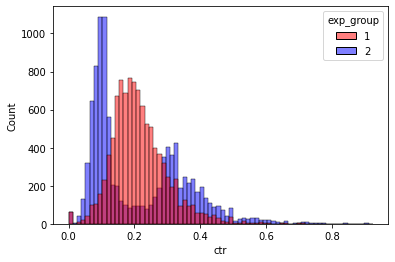

In [5]:
# We build the distribution of CTR by groups and evaluate it.
# Строим распределение CTR по группам и оцениваем его "наглаз".

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

The histogram clearly shows the difference in the distribution of CTR in the two groups.                                     На гистограмме явно видно различие в расспределении CTR в двух группах

Moreover, the second group has a distribution with two vertices.        
Более того, у второй группы распределение с двумя вершинами

In [6]:
# Test Mann-Whitneyu

mann = stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')
print(f' p-value = {mann.pvalue}')


 p-value = 6.0376484617779035e-56


The Mann-Whitney test showed a significant difference.  
Тест Манна-Витни "покрасился" и показал значимое различие

-------------------------------------------------------------

In [7]:
# Test on the smoothed CTR

def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    '''The function allows you to calculate the smoothed CTR.
     When a user's CTR is close to zero, we replace it with the global CTR.
     In other cases, the CTR remains almost unchanged.
     This helps us get rid of the "noise" generated by users with low views. 
    Функция позволяет посчитать сглаженный CTR. 
    Когда у пользователя CTR близок к нулю, мы заменяем его на глобальный CTR.
    В остальных случаях CTR остаётся почти неизменным.
    Это помогает нам избавиться от "шума", который производят пользователи с малым количеством просмотров'''
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

# Calculate the global CTR in both groups. Считаем глобальный CTR в двух группах
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [8]:
# We form databases of two groups with additional columns in which we prescribe a smoothed CTR for each user
# Формируем базы данных двух групп с дополнительными колонками, в которых прописываем сглаженный CTR для каждого пользователя
group1 = pd.DataFrame()
group2 = pd.DataFrame()
group1['smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [9]:
#Perform t-test on the smoothed data
#Проводим t-test на сглаженных данных

t_test_smoothed = stats.ttest_ind(group1.smoothed_ctr, group2.smoothed_ctr, equal_var=False)
print(f' p-value = {t_test_smoothed.pvalue}')

 p-value = 0.293394244281171


T-test on smoothed data shows significant differences     
T-test на сглаженных данных показывает значимые различия

<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

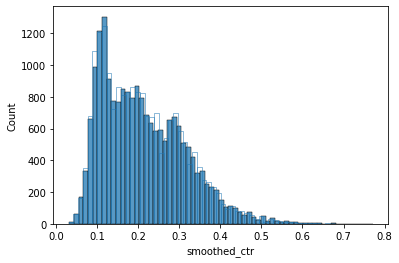

In [10]:
# Plot the distributions of the smoothed CTR in two groups
# Строим расспределения сглаженного CTR в двух группах

sns.histplot(group1.smoothed_ctr, kde = False)
sns.histplot(group2.smoothed_ctr, kde = False, fill = False)

--------------------

# Since the main goal is to compare the total CTR of the two groups, not the CTR of each user, we run into the problem that the total CTR is a single number.

Так как главной задачей является сравнение общего CTR в двух группах, а не CTR каждого пользователя, мы сталкиваемся с проблемой ,что общий CTR это одно число.

# To get around this problem, we generate pseudo-samples from the groups using the Poisson bootstrap and Bucket transform methods.      
Чтобы уйти от этой проблемы мы генериуем из групп псевдовыборки методами Пуассоновского бустрепа и Бакетным преобразованием

In [12]:
# Poisson bootstrap


def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    '''The function receives as input arrays with the values of 'like' and 'view' for users in the control and test groups.
     The function also receives the number of samples to be generated. Default is 2000 pcs.
     Next, the function counts how many times the 'like' value of each user will fall into each of the (2000) samples.
     Thus, samples are formed in each of the groups.
     poisson_bootstraps is an array with the weights of each value in each of the samples.
     At the output, the function returns two arrays of global CTR values for all samples in the control and test groups 
    
    Функция принимает на вход массивы со значениями лайков и просмотров по пользователям в контрольной и тестовой группах.
    Также функция принимает количество выборок, которые будут сгенерированны. По умолчанию это 2000 шт.
    Далее функция считает сколько раз значение like каждого пользователя попадёт в каждую из (2000)выборок. 
    Таким образом происходит формирование выборок в каждой из групп.
    poisson_bootstraps - массив с весами каждого значения в каждой из выборок.
    На выходе функция возвращает два массива из значений глобальнх CTR по всем выборкам в контрольной и тестовой группах '''

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [13]:
#Generate arrays with likes and views data in the control and test groups
#Формируем массивы с данными лайков и просмотров в контрольной и тестовой группах

likes1 = df[df.exp_group == 1].likes.to_numpy() # Array with 'like' in the control group. Массив с лайками в контрольной группе
views1 = df[df.exp_group == 1].views.to_numpy() # Array with 'view' in the control group. Массив с просмотрами в контрольной группе
likes2 = df[df.exp_group == 2].likes.to_numpy() # Array with 'like' in the test group. Массив с лайками в тестовой группе
views2 = df[df.exp_group == 2].views.to_numpy() # Array with 'view' in the test group. Массив с просмотрами в тестовой группе

In [14]:
# Calculate the distribution of global CTR in the control and test groups, using pseudo-samples in them.
# Считаем распределение глобальных CTR в контрольной и тестовой группах, используя псевдовыборки в них. 
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)


<AxesSubplot:ylabel='Count'>

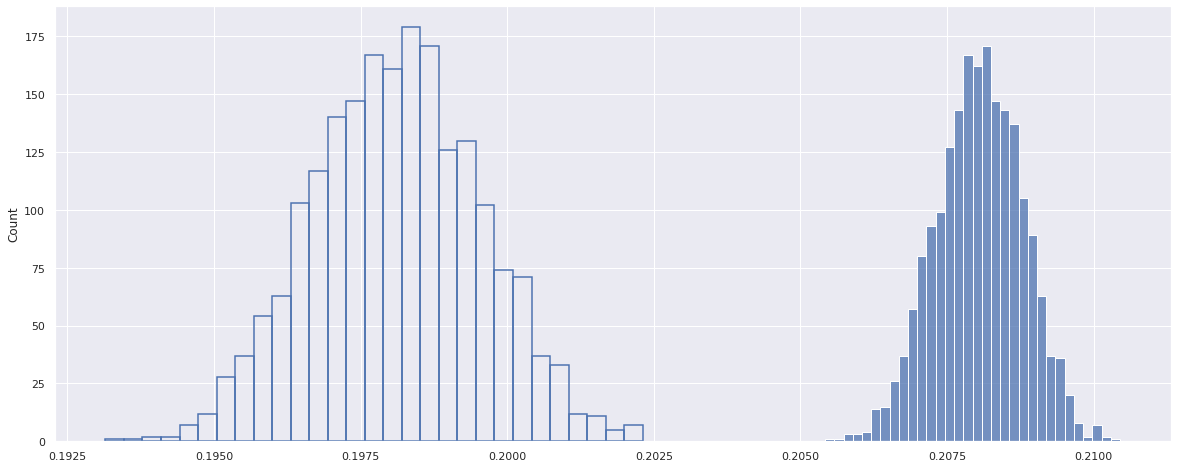

In [15]:
# We build the distributions of global CTRs in the control and test groups according to their pseudo-samples
# Строим распределения глобальных CTR в контрольной и тестовой группах по их псевдовыборкам
sns.set(rc={'figure.figsize':(20,8)})
sns.histplot(ctr1)
sns.histplot(ctr2, fill = False)

Graphs do not intersect, T-test should show p-value = 0.  
Графики не пересекаются, Т-тест должен показать p-value = 0.

At the same time, note that the test group shows a smaller global CTR  
При этом заметим, что  тестовая группа показывает меньший глобальный CTR

------------

In [16]:
t_test_gl = stats.ttest_ind(ctr1, ctr2, equal_var=False)
print(f' p-value = {t_test_gl.pvalue}')

 p-value = 0.0


<AxesSubplot:ylabel='Count'>

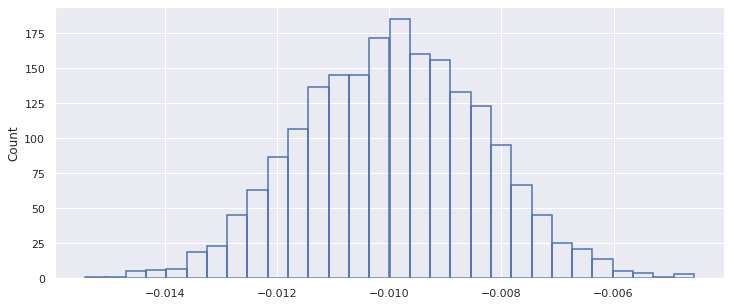

In [17]:
#Plot the difference between global CTRs in groups
#Потроим разницу между глобальными CTR в группах
sns.set(rc={'figure.figsize':(12,5)})
sns.histplot(ctr2 - ctr1, fill= False)

The difference between global CTRs in the test and control groups is negative and does not cross 0.  
Разница между глобальными CTR в тестовой и контрольной группе отрицательная, не пересекает 0.

We may state that the test group showed worse results than the control group.  
Можно утверждать что тестовая группа показала худшие результаты чем контрольная

-----------------------------------------------------------------------------------------------------

In [19]:
# Request data for the bucket transform
# Запрос данных для бакетного преобразования

qb = """
SELECT exp_group, bucket,
sum(likes)/sum(views) as bucket_ctr
    FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20230120.feed_actions 
    WHERE toDate(time) between '2023-01-01' and '2023-01-07' and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_b = pandahouse.read_clickhouse(qb, connection=connection)

In [20]:
# T-test over bucket transform of control and test groups
# T-test поверх бакетного преобразования контрольной и тестовой групп
t_test = stats.ttest_ind(df_b[df_b.exp_group == 1].bucket_ctr,
                df_b[df_b.exp_group == 2].bucket_ctr,
                equal_var=False)
print(f' p-value = {t_test.pvalue}')

 p-value = 3.4455951649945907e-07


In [21]:
# Mann-Whitney U-test over control and test groups batch conversion
# Mann-Whitneyu-test поверх бакетного преобразования контрольной и тестовой групп
mann_test = stats.mannwhitneyu(df_b[df_b.exp_group == 1].bucket_ctr, 
                   df_b[df_b.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')
print(f' p-value = {mann_test.pvalue}')

 p-value = 2.859963936492646e-07


----------------------------------------------------------------------------------

Initial tests on custom CTRs produced mixed results.
The t-test on the raw data did not see a difference between the groups.
The t-test on the smoothed CTR and the Mann-Whitneyu test saw significant differences between the groups.
Looking at the distributions, one can see a clear difference in the groups. In the test group, the distribution is double-humped.
The t-test on the raw data considers the difference in the mean and, apparently, the mean of the two-humped distribution accidentally coincided with the mean in the distribution of the control group.

The double-humped distribution in the control group could be due to the fact that the innovations were rolled out to a group with a certain number of interested users who actively liked with a small number of views.
However, the main users did not really appreciate the innovations, which can be seen in the further study of the global CTR.

Global CTR research methods show the negative impact of innovations on the measured metric.
In my opinion, you should not recommend introducing changes for the entire application.

Первоначальные тесты на пользовательских CTR давали разные результаты.          
Т-тест на первичных данных не видел разниы в группах.         
Т-тест на сглаженном CTR и тест Mann-Whitneyu видел значительные различия в группах.
Посмотрев на распределения можно увидеть явное различие в группах. В тестовой группе распределение двугорбое.   
Т-тест на первичных данных считает различие в среднем и, видимо, среднее двугорбого распределения случайно совпало со средним в распределении контрольной группы.       

Двугорбое распределение в контрольной группе могло произойти из-за того, что нововедения выкатили на группу с некоторым количеством заинтересованных пользователей, которые активно лайкали при небольшом количестве просмотров.           
Однако основные пользователи не слишком оценили нововедения, что можно увидеть на дальнейшем исследовании глобального CTR.

Методы исследования глобального CTR показывают отрицательное влияние нововедений на измеряемую метрику.       
На мой взгляд, не стоит рекомендовать вводить изменения для всего приложения
